# Imports

In [19]:
import json
import re
import string
import scipy

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm_notebook as tqdm
from nltk.sentiment.util import mark_negation
from nltk import wordpunct_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn.linear_model import LinearRegression,SGDClassifier,ElasticNet,LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,f1_score,mean_squared_error,confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

# Constants

In [21]:
train_path = 'data/train.json'
dev_path = 'data/dev.json'

translator = str.maketrans("","", string.punctuation)
# stemmer = SnowballStemmer("english", ignore_stopwords=True)

# Function Defs

In [22]:
def read_file(path):
    data_X = []
    data_Y = []
    with open(path, 'r') as data_file:
        line = data_file.readline()
        while line:
            data = json.loads(line)
            data_X.append(data['review'])
            data_Y.append(data['ratings'])
            line = data_file.readline()
    return data_X,data_Y

def get_metrics_from_pred(y_pred,y_true):
    mse = mean_squared_error(y_pred,y_true)
    
    try:
        f1_scor = f1_score(y_true, y_pred, average='weighted')
        acc = accuracy_score(y_true, y_pred)
        conf_matrix = confusion_matrix(y_true,y_pred)
      
    except:
        y_pred = np.round(y_pred)
        
        f1_scor = f1_score(y_true, y_pred, average='weighted')
        acc = accuracy_score(y_true, y_pred)
        conf_matrix = confusion_matrix(y_true,y_pred)
        
    print("MSE = ",mse," F1 = ",f1_scor," Accuracy = ",acc)
    plt.matshow(conf_matrix)
    plt.colorbar()
    
def get_metrics(model,X,y_true):
    y_pred = model.predict(X)
    get_metrics_from_pred(y_pred,y_true)
    
def get_metrics_using_probs(model,X,y_true):
    y_pred = model.predict_proba(X)
    y_pred = np.average(y_pred,axis=1, weights=[1,2,3,4,5])*15
    get_metrics_from_pred(y_pred,y_true)
    
def remove_repeats(sentence):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", sentence)

def tokenizer1(sentence):
    sentence = sentence.translate(translator)      # Remove punctuations
    sentence = sentence.lower()                    # Convert to lowercase
    sentence = re.sub(r'\d+', '', sentence)        # Remove Numbers
    sentence = remove_repeats(sentence)            # Remove repeated characters
#     sentence = sentence.strip()                    # Remove Whitespaces
    tokens = wordpunct_tokenize(sentence)          # Tokenize
#     tokens = word_tokenize(sentence)          # Tokenize
    
#     for i in range(len(tokens)):                    # Stem word
#         tokens[i] = stemmer.stem(tokens[i])
    return tokens

In [23]:
# emoticon_string = r"""
#     (?:
#       [<>]?
#       [:;=8]                     # eyes
#       [\-o\*\']?                 # optional nose
#       [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth      
#       |
#       [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth
#       [\-o\*\']?                 # optional nose
#       [:;=8]                     # eyes
#       [<>]?
#     )"""

# # The components of the tokenizer:
# regex_strings = (
#     # Phone numbers:
#     r"""
#     (?:
#       (?:            # (international)
#         \+?[01]
#         [\-\s.]*
#       )?            
#       (?:            # (area code)
#         [\(]?
#         \d{3}
#         [\-\s.\)]*
#       )?    
#       \d{3}          # exchange
#       [\-\s.]*   
#       \d{4}          # base
#     )"""
#     ,
#     # Emoticons:
#     emoticon_string
#     ,    
#     # HTML tags:
#      r"""<[^>]+>"""
#     ,
#     # Twitter username:
#     r"""(?:@[\w_]+)"""
#     ,
#     # Twitter hashtags:
#     r"""(?:\#+[\w_]+[\w\'_\-]*[\w_]+)"""
#     ,
#     # Remaining word types:
#     r"""
#     (?:[a-z][a-z'\-_]+[a-z])       # Words with apostrophes or dashes.
#     |
#     (?:[+\-]?\d+[,/.:-]\d+[+\-]?)  # Numbers, including fractions, decimals.
#     |
#     (?:[\w_]+)                     # Words without apostrophes or dashes.
#     |
#     (?:\.(?:\s*\.){1,})            # Ellipsis dots. 
#     |
#     (?:\S)                         # Everything else that isn't whitespace.
#     """
#     )

# ######################################################################
# # This is the core tokenizing regex:
    
# word_re = re.compile(r"""(%s)""" % "|".join(regex_strings), re.VERBOSE | re.I | re.UNICODE)

# # The emoticon string gets its own regex so that we can preserve case for them as needed:
# emoticon_re = re.compile(regex_strings[1], re.VERBOSE | re.I | re.UNICODE)

# # These are for regularizing HTML entities to Unicode:
# html_entity_digit_re = re.compile(r"&#\d+;")
# html_entity_alpha_re = re.compile(r"&\w+;")
# amp = "&amp;"

# negation_re =  re.compile(r"""
#                 never|no|nothing|nowhere|noone|none|not|
#                 havent|hasnt|hadnt|cant|couldnt|shouldnt|
#                 wont|wouldnt|dont|doesnt|didnt|isnt|arent|aint|
#                 n't|
#                 haven't|hasn't|hadn't|can't|couldn't|shouldn't|
#                 won't|wouldn't|don't|doesn't|didn't|isn't|aren't|ain't
#                 """,re.VERBOSE )

# clause_level_re = re.compile(r"""^[.:;!?]$""",re.VERBOSE )
# ######################################################################

# class Tokenizer:
#     def __init__(self, preserve_case=False):
#         self.preserve_case = preserve_case

#     def tokenize(self, s):
#         """
#         Argument: s -- any string or unicode object
#         Value: a tokenize list of strings; conatenating this list returns the original string if preserve_case=False
#         """        
#         # Try to ensure unicode:
# #         try:
# #             s = unicode(s)
# #         except UnicodeDecodeError:
# #             s = str(s).encode('string_escape')
# #             s = unicode(s)
#         # Fix HTML character entitites:
#         # Tokenize:
#         words = word_re.findall(s)

#         # Possible alter the case, but avoid changing emoticons like :D into :d:
#         if not self.preserve_case:            
#             words = list(map((lambda x : x if emoticon_re.search(x) else x.lower()), words))
# #         negator = False
        
# #         for i in range(len(words)):
# #             word = words[i]
# #             if(negation_re.match(word)):
# #                 negator = !negator
# #             elif(clause_level_re.match(word)):
# #                 negator = False
# #             elif(negator):
# #                 words[i] = word+"_NEG"
#         return words
    
    
# tok = Tokenizer().tokenize

In [24]:
tokenize = tokenizer1
# tokenize = tok

In [25]:
# for i in tqdm(range(len(X_train))):
#     tokenize(X_train[i])

# for i in range(200,600):
#     print(tokenize(X_train[i]))

In [26]:
X_train,Y_train = read_file(train_path)
X_dev,Y_dev = read_file(dev_path)

In [27]:
# processed_stopwords = []

# for word in stopwords.words('english'):
#     processed_stopwords += tokenize(word)
    
# # print(processed_stopwords)

In [28]:
# vectorizer = TfidfVectorizer(strip_accents='ascii',
#                              lowercase=True,
#                              tokenizer=tokenize,
#                              stop_words=processed_stopwords,
#                              ngram_range=(1,1),
#                              binary=True,
#                              norm='l2',
#                              analyzer='word')

# vectorizer = TfidfVectorizer(binary=True,tokenizer=tokenize)

# vectorizer = TfidfVectorizer(tokenizer=tokenize)

vectorizer = TfidfVectorizer(tokenizer=tokenize,ngram_range=(1,2))

# vectorizer = CountVectorizer(tokenizer=tokenize,ngram_range=(1,2))

X_train_counts = vectorizer.fit_transform(X_train)
X_dev_counts = vectorizer.transform(X_dev)

In [ ]:
# print(X_train_counts)

In [ ]:
# from sklearn import preprocessing

# scaler = preprocessing.StandardScaler(with_mean=False).fit(X_train_counts)
# X_train_counts = scaler.transform(X_train_counts)
# X_dev_counts = scaler.transform(X_dev_counts)

In [ ]:
# print(X_train_counts)

* Try Removeding whole numbers
* Try seperating number and text
* Try replacing 000ps by ooops
* Try removing repeated characters like sssslllleeeepppp.

# Baseline

In [ ]:
# all_5 = list(5*np.ones([len(Y_dev),]))
# get_metrics_from_pred(all_5,Y_dev)

# Trying Multinomial Naive Bayes

In [ ]:
# model = MultinomialNB()
# model.fit(X_train_counts,Y_train)

In [ ]:
# get_metrics(model,X_dev_counts,Y_dev)
# get_metrics_using_probs(model,X_dev_counts,Y_dev)

# Trying Logistic Regression

In [22]:
model = LogisticRegression(verbose=1,n_jobs=7,solver='sag',multi_class='ovr')
model.fit(X_train_counts,Y_train)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


convergence after 18 epochs took 389 seconds
convergence after 19 epochs took 405 seconds
convergence after 19 epochs took 406 seconds
convergence after 20 epochs took 412 seconds
convergence after 21 epochs took 418 seconds


[Parallel(n_jobs=7)]: Done   5 out of   5 | elapsed:  7.0min finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=7,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=1, warm_start=False)

MSE =  0.53488  F1 =  0.6910581415118381  Accuracy =  0.707255
MSE =  0.39078704909456885  F1 =  0.6600416234970532  Accuracy =  0.647235


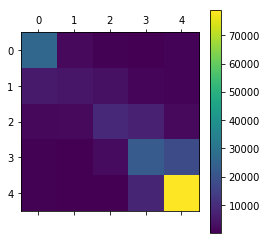

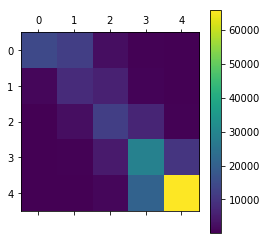

In [23]:
get_metrics(model,X_dev_counts,Y_dev)
get_metrics_using_probs(model,X_dev_counts,Y_dev)

In [ ]:
# model = LogisticRegression(verbose=1,n_jobs=7,class_weight='balanced',multi_class='ovr',solver='liblinear')
# model.fit(X_train_counts,Y_train)

In [ ]:
# get_metrics(model,X_dev_counts,Y_dev)
# get_metrics_using_probs(model,X_dev_counts,Y_dev)

In [ ]:
# model = LogisticRegression(verbose=1,n_jobs=7,class_weight='balanced',multi_class='multinomial',solver='lbfgs')
# model.fit(X_train_counts,Y_train)

In [ ]:
# get_metrics(model,X_dev_counts,Y_dev)
# get_metrics_using_probs(model,X_dev_counts,Y_dev)

In [ ]:
# model = LogisticRegression(verbose=1,n_jobs=7,class_weight='balanced',multi_class='ovr',solver='liblinear',penalty='l1')
# model.fit(X_train_counts,Y_train)

In [ ]:
# get_metrics(model,X_dev_counts,Y_dev)
# get_metrics_using_probs(model,X_dev_counts,Y_dev)

In [ ]:
# model = LogisticRegression(verbose=1,n_jobs=7,class_weight='balanced',multi_class='multinomial',solver='saga',penalty='l1')
# model.fit(X_train_counts,Y_train)

In [ ]:
# get_metrics(model,X_dev_counts,Y_dev)
# get_metrics_using_probs(model,X_dev_counts,Y_dev)

# Linear Regression

In [ ]:
# model = LinearRegression(n_jobs=7)
# model.fit(X_train_counts,Y_train)

In [ ]:
# get_metrics(model,X_dev_counts,Y_dev)

# SGD Classifier

In [ ]:
# model = SGDClassifier(n_jobs=7,verbose=True)
# model.fit(X_train_counts,Y_train)

In [ ]:
# get_metrics(model,X_dev_counts,Y_dev)

# ElasticNet

In [ ]:
# model = ElasticNet()
# model.fit(X_train_counts,Y_train)

In [ ]:
# get_metrics(model,X_dev_counts,Y_dev)

# GradientBoostingClassifier

In [ ]:
# model = GradientBoostingClassifier(verbose=True)
# model.fit(X_train_counts,Y_train)

In [ ]:
# get_metrics(model,X_dev_counts,Y_dev)

# Complicated Model ( Tree with two branches 1-3 and 4-5)

In [ ]:
indices = np.where(list(map(lambda x:x>3,Y_train)))[0]
X_train_counts_4_5 = X_train_counts[indices]
Y_train_4_5 = [Y_train[j] for j in indices]

indices = np.where(list(map(lambda x:x<=3,Y_train)))[0]
X_train_counts_1_3 = X_train_counts[indices]
Y_train_1_3 = [Y_train[j] for j in indices]

In [ ]:
Y_modified = list(map(lambda x:int(x>3),Y_train))

In [ ]:
model1 = LogisticRegression(verbose=1,n_jobs=7,solver='sag')
model1.fit(X_train_counts,Y_modified)

In [ ]:
model2 = LogisticRegression(verbose=1,n_jobs=7,solver='sag')
model2.fit(X_train_counts_4_5,Y_train_4_5)

In [ ]:
model3 = LogisticRegression(verbose=1,n_jobs=7,solver='sag',multi_class='ovr')
model3.fit(X_train_counts_1_3,Y_train_1_3)

In [ ]:
pred1 = model1.predict(X_dev_counts)
pred2 = model2.predict_proba(X_dev_counts)
pred3 = model3.predict_proba(X_dev_counts)

pred = []

for i in tqdm(range(len(pred1))):
    if(pred1[i] == 1):
        pred.append(pred2[i][0]*4.0 + pred2[i][1]*5.0)
    else:
        pred.append(pred3[i][0]*1.0 + pred3[i][1]*2.0 + pred3[i][2]*3.0)

get_metrics_from_pred(pred,Y_dev)

# Another Try (Tree with negative ,neutral and positive review)

In [24]:
indices = np.where(list(map(lambda x:x>3,Y_train)))[0]
X_train_counts_4_5 = X_train_counts[indices]
Y_train_4_5 = [Y_train[j] for j in indices]

indices = np.where(list(map(lambda x:x<3,Y_train)))[0]
X_train_counts_1_2 = X_train_counts[indices]
Y_train_1_2 = [Y_train[j] for j in indices]

indices = np.where(list(map(lambda x:x==3,Y_train)))[0]
X_train_counts_3 = X_train_counts[indices]
Y_train_3 = [Y_train[j] for j in indices]

In [25]:
def modif(x):
    if (x==3):
        return 1
    elif(x>3):
        return 2
    else:
        return 0

Y_modified = list(map(lambda x: modif(x),Y_train))

In [26]:
model1 = LogisticRegression(verbose=1,n_jobs=7,solver='sag',multi_class='ovr')
model1.fit(X_train_counts,Y_modified)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


convergence after 19 epochs took 215 seconds
convergence after 19 epochs took 216 seconds
convergence after 20 epochs took 221 seconds


[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:  3.7min finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=7,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=1, warm_start=False)

In [27]:
model2 = LogisticRegression(verbose=1,n_jobs=7,solver='sag')
model2.fit(X_train_counts_4_5,Y_train_4_5)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


convergence after 20 epochs took 66 seconds


[Parallel(n_jobs=7)]: Done   1 out of   1 | elapsed:  1.1min finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=7,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=1, warm_start=False)

In [28]:
model3 = LogisticRegression(verbose=1,n_jobs=7,solver='sag')
model3.fit(X_train_counts_1_2,Y_train_1_2)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


convergence after 20 epochs took 33 seconds


[Parallel(n_jobs=7)]: Done   1 out of   1 | elapsed:   33.1s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=7,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=1, warm_start=False)


MSE =  0.46026449870061914  F1 =  0.692464233094942  Accuracy =  0.707425


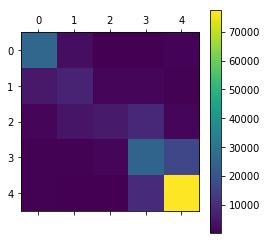

In [29]:
pred1 = model1.predict(X_dev_counts)
pred1_p = model1.predict_proba(X_dev_counts)
pred2 = model2.predict_proba(X_dev_counts)
pred3 = model3.predict_proba(X_dev_counts)

pred = []

for i in tqdm(range(len(pred1))):
    if(pred1[i] == 0):
        pred.append(pred3[i][0]*1.0 + pred3[i][1]*2.0)
    elif(pred1[i] == 1):
        pred.append(pred1_p[i][0]*1.5 + pred1_p[i][1]*3 + pred1_p[i][2]*4.5)
    elif(pred1[i] == 2):
        pred.append(pred2[i][0]*4.0 + pred2[i][1]*5.0)

get_metrics_from_pred(pred,Y_dev)


MSE =  0.3752686829087851  F1 =  0.6731445579059282  Accuracy =  0.66167


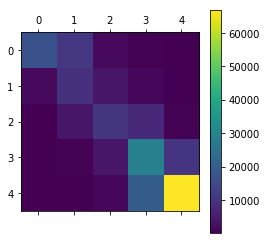

In [30]:
pred_n_3_p = model1.predict_proba(X_dev_counts)
pred_4_5 = model2.predict_proba(X_dev_counts)
pred_1_2 = model3.predict_proba(X_dev_counts)

pred = []

for i in tqdm(range(len(pred1))):
    pred.append(pred_n_3_p[i][0]*pred_1_2[i][0]*1.0 + pred_n_3_p[i][0]*pred_1_2[i][1]*2.0 + pred_n_3_p[i][1]*3.0 + pred_n_3_p[i][2]*pred_4_5[i][0]*4.0 + pred_n_3_p[i][2]*pred_4_5[i][1]*5.0)

get_metrics_from_pred(pred,Y_dev)

# Voting Classifier (With simple ovr logistive regression and multinomial naive bayes)

In [ ]:
# m1 = LogisticRegression(verbose=1,n_jobs=7,solver='sag',multi_class='ovr')
# m2 = MultinomialNB()

# model = VotingClassifier(estimators=[('lr', m1),('gnb', m2)],voting='soft')
# model.fit(X_train_counts,Y_train)                                     

In [ ]:
# get_metrics(model,X_dev_counts,Y_dev)
# get_metrics_using_probs(model,X_dev_counts,Y_dev)

# Binary Logistics Everywhere (Tree with base classified as neutral or 1-3&4-5)

In [10]:
indices = np.where(list(map(lambda x: x!=3,Y_train)))[0]
X_train_counts_p_n = X_train_counts[indices]
Y_train_p_n = [1 if Y_train[j]>3 else 0 for j in indices]

indices = np.where(list(map(lambda x:x>3,Y_train)))[0]
X_train_counts_4_5 = X_train_counts[indices]
Y_train_4_5 = [Y_train[j] for j in indices]

indices = np.where(list(map(lambda x:x<3,Y_train)))[0]
X_train_counts_1_2 = X_train_counts[indices]
Y_train_1_2 = [Y_train[j] for j in indices]

In [11]:
def modif(x):
    if (x==3):
        return 1
    else:
        return 0

Y_modified = list(map(lambda x: modif(x),Y_train))

In [12]:
model_neutral = LogisticRegression(verbose=1,n_jobs=7,solver='sag')
model_neutral.fit(X_train_counts,Y_modified)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


convergence after 19 epochs took 100 seconds


[Parallel(n_jobs=7)]: Done   1 out of   1 | elapsed:  1.7min finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=7,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=1, warm_start=False)

In [13]:
model_n_p = LogisticRegression(verbose=1,n_jobs=7,solver='sag')
model_n_p.fit(X_train_counts_p_n,Y_train_p_n)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


convergence after 18 epochs took 82 seconds


[Parallel(n_jobs=7)]: Done   1 out of   1 | elapsed:  1.4min finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=7,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=1, warm_start=False)

In [14]:
model_4_5 = LogisticRegression(verbose=1,n_jobs=7,solver='sag')
model_4_5.fit(X_train_counts_4_5,Y_train_4_5)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


convergence after 23 epochs took 72 seconds


[Parallel(n_jobs=7)]: Done   1 out of   1 | elapsed:  1.2min finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=7,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=1, warm_start=False)

In [15]:
model_1_2 = LogisticRegression(verbose=1,n_jobs=7,solver='sag')
model_1_2.fit(X_train_counts_1_2,Y_train_1_2)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


convergence after 19 epochs took 30 seconds


[Parallel(n_jobs=7)]: Done   1 out of   1 | elapsed:   29.6s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=7,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=1, warm_start=False)


MSE =  0.38107410386825097  F1 =  0.6747373529661828  Accuracy =  0.66288


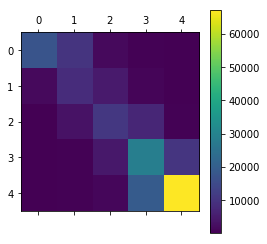

In [19]:
pred_neutral = model_neutral.predict_proba(X_dev_counts)
pred_n_p = model_n_p.predict_proba(X_dev_counts)
pred_1_2 = model_1_2.predict_proba(X_dev_counts)
pred_4_5 = model_4_5.predict_proba(X_dev_counts)

pred = []

for i in tqdm(range(len(pred_neutral))):
    pred.append(pred_neutral[i][1]*3.0 +
                pred_neutral[i][0]*pred_n_p[i][0]*pred_1_2[i][0]*1.0 +
                pred_neutral[i][0]*pred_n_p[i][0]*pred_1_2[i][1]*2.0+
                pred_neutral[i][0]*pred_n_p[i][1]*pred_4_5[i][0]*4.0+
                pred_neutral[i][0]*pred_n_p[i][1]*pred_4_5[i][1]*5.0)
get_metrics_from_pred(pred,Y_dev)


MSE =  0.534325  F1 =  0.6853456518460236  Accuracy =  0.70119


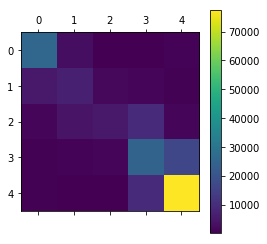

In [21]:
pred_neutral_c = model_neutral.predict(X_dev_counts)
pred_neutral = model_neutral.predict_proba(X_dev_counts)
pred_n_p_c = model_n_p.predict(X_dev_counts)
pred_n_p = model_n_p.predict_proba(X_dev_counts)
pred_1_2_c = model_1_2.predict(X_dev_counts)
pred_1_2 = model_1_2.predict_proba(X_dev_counts)
pred_4_5_c = model_4_5.predict(X_dev_counts)
pred_4_5 = model_4_5.predict_proba(X_dev_counts)

pred = []

for i in tqdm(range(len(pred_neutral))):
    if(pred_neutral_c[i] == 1):
        pred.append(3)
    else:
        if(pred_n_p_c[i] == 0):
            pred.append(pred_1_2_c[i])
        else:
            pred.append(pred_4_5_c[i])
get_metrics_from_pred(pred,Y_dev)

# Another Try (Full tree leaning towards 1)

In [31]:
indices = np.where(list(map(lambda x: x<=3,Y_train)))[0]
X_train_counts_12_3 = X_train_counts[indices]
Y_train_12_3 = [1 if Y_train[j]==3 else 0 for j in indices]

indices = np.where(list(map(lambda x:x>3,Y_train)))[0]
X_train_counts_4_5 = X_train_counts[indices]
Y_train_4_5 = [Y_train[j] for j in indices]

indices = np.where(list(map(lambda x:x<3,Y_train)))[0]
X_train_counts_1_2 = X_train_counts[indices]
Y_train_1_2 = [Y_train[j] for j in indices]

In [32]:
def modif(x):
    if (x>3):
        return 1
    else:
        return 0

Y_modified = list(map(lambda x: modif(x),Y_train))

In [33]:
model_123_45 = LogisticRegression(verbose=1,n_jobs=7,solver='sag')
model_123_45.fit(X_train_counts,Y_modified)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


convergence after 18 epochs took 100 seconds


[Parallel(n_jobs=7)]: Done   1 out of   1 | elapsed:  1.7min finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=7,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=1, warm_start=False)

In [34]:
model_4_5 = LogisticRegression(verbose=1,n_jobs=7,solver='sag')
model_4_5.fit(X_train_counts_4_5,Y_train_4_5)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


convergence after 21 epochs took 68 seconds


[Parallel(n_jobs=7)]: Done   1 out of   1 | elapsed:  1.1min finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=7,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=1, warm_start=False)

In [35]:
model_12_3 = LogisticRegression(verbose=1,n_jobs=7,solver='sag')
model_12_3.fit(X_train_counts_12_3,Y_train_12_3)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


convergence after 21 epochs took 47 seconds


[Parallel(n_jobs=7)]: Done   1 out of   1 | elapsed:   46.5s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=7,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=1, warm_start=False)

In [36]:
model_1_2 = LogisticRegression(verbose=1,n_jobs=7,solver='sag')
model_1_2.fit(X_train_counts_1_2,Y_train_1_2)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


convergence after 19 epochs took 29 seconds


[Parallel(n_jobs=7)]: Done   1 out of   1 | elapsed:   29.4s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=7,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=1, warm_start=False)


MSE =  0.3735370102976789  F1 =  0.6765698351917488  Accuracy =  0.666125


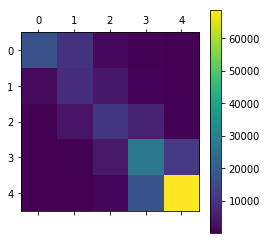

In [37]:
pred_123_45 = model_123_45.predict_proba(X_dev_counts)
pred_12_3 = model_12_3.predict_proba(X_dev_counts)
pred_1_2 = model_1_2.predict_proba(X_dev_counts)
pred_4_5 = model_4_5.predict_proba(X_dev_counts)

pred = []

for i in tqdm(range(len(pred_neutral))):
    pred.append(pred_123_45[i][0]*pred_12_3[i][0]*pred_1_2[i][0]*1.0+
                pred_123_45[i][0]*pred_12_3[i][0]*pred_1_2[i][1]*2.0+
                pred_123_45[i][0]*pred_12_3[i][1]*3.0+
                pred_123_45[i][1]*pred_4_5[i][0]*4.0+
                pred_123_45[i][1]*pred_4_5[i][1]*5.0)
get_metrics_from_pred(pred,Y_dev)

# Another Try (Full tree leaning towards 5)

In [10]:
indices = np.where(list(map(lambda x: x>=3,Y_train)))[0]
X_train_counts_3_45 = X_train_counts[indices]
Y_train_3_45 = [0 if Y_train[j]==3 else 1 for j in indices]

indices = np.where(list(map(lambda x:x>3,Y_train)))[0]
X_train_counts_4_5 = X_train_counts[indices]
Y_train_4_5 = [Y_train[j] for j in indices]

indices = np.where(list(map(lambda x:x<3,Y_train)))[0]
X_train_counts_1_2 = X_train_counts[indices]
Y_train_1_2 = [Y_train[j] for j in indices]

In [18]:
# print(X_train_counts[0])
# print('hey')
# print(X_train_counts_1_2[0])

In [19]:
def modif(x):
    if (x>=3):
        return 1
    else:
        return 0

Y_modified = list(map(lambda x: modif(x),Y_train))

In [20]:
model_12_345 = LogisticRegression(verbose=1,n_jobs=7,solver='sag')
model_12_345.fit(X_train_counts,Y_modified)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


convergence after 18 epochs took 95 seconds


[Parallel(n_jobs=7)]: Done   1 out of   1 | elapsed:  1.6min finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=7,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=1, warm_start=False)

In [21]:
model_4_5 = LogisticRegression(verbose=1,n_jobs=7,solver='sag')
model_4_5.fit(X_train_counts_4_5,Y_train_4_5)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


convergence after 22 epochs took 68 seconds


[Parallel(n_jobs=7)]: Done   1 out of   1 | elapsed:  1.1min finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=7,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=1, warm_start=False)

In [22]:
model_3_45 = LogisticRegression(verbose=1,n_jobs=7,solver='sag')
model_3_45.fit(X_train_counts_3_45,Y_train_3_45)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


convergence after 18 epochs took 70 seconds


[Parallel(n_jobs=7)]: Done   1 out of   1 | elapsed:  1.2min finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=7,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=1, warm_start=False)

In [23]:
model_1_2 = LogisticRegression(verbose=1,n_jobs=7,solver='sag')
model_1_2.fit(X_train_counts_1_2,Y_train_1_2)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


convergence after 20 epochs took 30 seconds


[Parallel(n_jobs=7)]: Done   1 out of   1 | elapsed:   30.3s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=7,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=1, warm_start=False)


MSE =  0.376282766283543  F1 =  0.6767494927435395  Accuracy =  0.66589


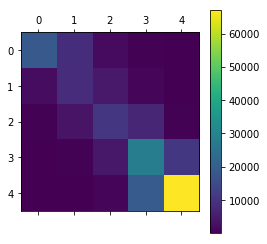

In [25]:
pred_12_345 = model_12_345.predict_proba(X_dev_counts)
pred_3_45 = model_3_45.predict_proba(X_dev_counts)
pred_1_2 = model_1_2.predict_proba(X_dev_counts)
pred_4_5 = model_4_5.predict_proba(X_dev_counts)

pred = []

for i in tqdm(range(len(pred_12_345))):
    pred.append(pred_12_345[i][1]*pred_3_45[i][1]*pred_4_5[i][1]*5.0+
                pred_12_345[i][1]*pred_3_45[i][1]*pred_4_5[i][0]*4.0+
                pred_12_345[i][1]*pred_3_45[i][0]*3.0+
                pred_12_345[i][0]*pred_1_2[i][1]*2.0+
                pred_12_345[i][0]*pred_1_2[i][0]*1.0)
get_metrics_from_pred(pred,Y_dev)

# Another Try

In [26]:
indices = np.where(list(map(lambda x: x>=3,Y_train)))[0]
X_train_counts_3_45 = X_train_counts[indices]
Y_train_3_45 = [0 if Y_train[j]==3 else 1 for j in indices]

indices = np.where(list(map(lambda x:x>3,Y_train)))[0]
X_train_counts_4_5 = X_train_counts[indices]
Y_train_4_5 = [Y_train[j] for j in indices]

indices = np.where(list(map(lambda x:x>1,Y_train)))[0]
X_train_counts_2_345 = X_train_counts[indices]
Y_train_2_345 = [ 0 if Y_train[j]== 2 else 1 for j in indices]

In [27]:
def modif(x):
    if (x>1):
        return 1
    else:
        return 0

Y_modified = list(map(lambda x: modif(x),Y_train))

In [28]:
model_1_2345 = LogisticRegression(verbose=1,n_jobs=7,solver='sag')
model_1_2345.fit(X_train_counts,Y_modified)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


convergence after 19 epochs took 105 seconds


[Parallel(n_jobs=7)]: Done   1 out of   1 | elapsed:  1.8min finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=7,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=1, warm_start=False)

In [29]:
model_2_345 = LogisticRegression(verbose=1,n_jobs=7,solver='sag')
model_2_345.fit(X_train_counts_2_345,Y_train_2_345)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


convergence after 18 epochs took 83 seconds


[Parallel(n_jobs=7)]: Done   1 out of   1 | elapsed:  1.4min finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=7,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=1, warm_start=False)

In [30]:
model_3_45 = LogisticRegression(verbose=1,n_jobs=7,solver='sag')
model_3_45.fit(X_train_counts_3_45,Y_train_3_45)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


convergence after 20 epochs took 79 seconds


[Parallel(n_jobs=7)]: Done   1 out of   1 | elapsed:  1.3min finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=7,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=1, warm_start=False)

In [31]:
model_4_5 = LogisticRegression(verbose=1,n_jobs=7,solver='sag')
model_4_5.fit(X_train_counts_4_5,Y_train_4_5)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


convergence after 22 epochs took 71 seconds


[Parallel(n_jobs=7)]: Done   1 out of   1 | elapsed:  1.2min finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=7,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=1, warm_start=False)


MSE =  0.3881355813542006  F1 =  0.6703307612500955  Accuracy =  0.658235


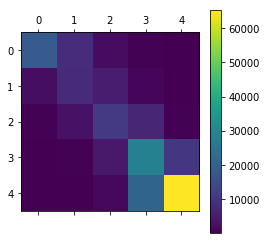

In [35]:
pred_1_2345 = model_1_2345.predict_proba(X_dev_counts)
pred_2_345 = model_2_345.predict_proba(X_dev_counts)
pred_3_45 = model_3_45.predict_proba(X_dev_counts)
pred_4_5 = model_4_5.predict_proba(X_dev_counts)

pred = []

for i in tqdm(range(len(pred_1_2345))):
    pred.append(pred_1_2345[i][0]*1.0+
                pred_1_2345[i][1]*pred_2_345[i][0]*2.0+
                pred_1_2345[i][1]*pred_2_345[i][1]*pred_3_45[i][0]*3.0+
                pred_1_2345[i][1]*pred_2_345[i][1]*pred_3_45[i][1]*pred_4_5[i][0]*4.0+
                pred_1_2345[i][1]*pred_2_345[i][1]*pred_3_45[i][1]*pred_4_5[i][1]*5.0)
get_metrics_from_pred(pred,Y_dev)

# Another Try

In [36]:
indices = np.where(list(map(lambda x: x<=3,Y_train)))[0]
X_train_counts_12_3 = X_train_counts[indices]
Y_train_12_3 = [1 if Y_train[j]==3 else 0 for j in indices]

indices = np.where(list(map(lambda x:x<3,Y_train)))[0]
X_train_counts_1_2 = X_train_counts[indices]
Y_train_1_2 = [Y_train[j] for j in indices]

indices = np.where(list(map(lambda x:x>1,Y_train)))[0]
X_train_counts_123_4 = X_train_counts[indices]
Y_train_123_4 = [ 1 if Y_train[j]== 4 else 0 for j in indices]

In [37]:
def modif(x):
    if (x>4):
        return 1
    else:
        return 0

Y_modified = list(map(lambda x: modif(x),Y_train))

In [38]:
model_1234_5 = LogisticRegression(verbose=1,n_jobs=7,solver='sag')
model_1234_5.fit(X_train_counts,Y_modified)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


convergence after 21 epochs took 111 seconds


[Parallel(n_jobs=7)]: Done   1 out of   1 | elapsed:  1.9min finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=7,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=1, warm_start=False)

In [39]:
model_123_4 = LogisticRegression(verbose=1,n_jobs=7,solver='sag')
model_123_4.fit(X_train_counts_123_4,Y_train_123_4)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


convergence after 20 epochs took 86 seconds


[Parallel(n_jobs=7)]: Done   1 out of   1 | elapsed:  1.4min finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=7,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=1, warm_start=False)

In [40]:
model_12_3 = LogisticRegression(verbose=1,n_jobs=7,solver='sag')
model_12_3.fit(X_train_counts_12_3,Y_train_12_3)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


convergence after 18 epochs took 38 seconds


[Parallel(n_jobs=7)]: Done   1 out of   1 | elapsed:   38.6s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=7,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=1, warm_start=False)

In [41]:
model_1_2 = LogisticRegression(verbose=1,n_jobs=7,solver='sag')
model_1_2.fit(X_train_counts_1_2,Y_train_1_2)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


convergence after 19 epochs took 28 seconds


[Parallel(n_jobs=7)]: Done   1 out of   1 | elapsed:   27.9s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=7,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=1, warm_start=False)


MSE =  0.45070899831864975  F1 =  0.6184001672270858  Accuracy =  0.5997


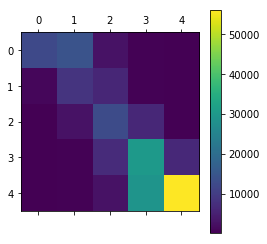

In [42]:
pred_1234_5 = model_1234_5.predict_proba(X_dev_counts)
pred_123_4 = model_123_4.predict_proba(X_dev_counts)
pred_12_3 = model_12_3.predict_proba(X_dev_counts)
pred_1_2 = model_1_2.predict_proba(X_dev_counts)

pred = []

for i in tqdm(range(len(pred_1234_5))):
    pred.append(pred_1234_5[i][1]*5.0+
                pred_1234_5[i][0]*pred_123_4[i][1]*4.0+
                pred_1234_5[i][0]*pred_123_4[i][0]*pred_12_3[i][1]*3.0+
                pred_1234_5[i][0]*pred_123_4[i][0]*pred_12_3[i][0]*pred_1_2[i][1]*2.0+
                pred_1234_5[i][0]*pred_123_4[i][0]*pred_12_3[i][0]*pred_1_2[i][0]*1.0)
get_metrics_from_pred(pred,Y_dev)